# Regional historical temperatures for PAGE-2020 regions

Dataset used: 

_Ilyas, M., Brierley, C.M. and Guillas, S., 2017. Uncertainty in regional temperatures inferred from sparse global observations: Application to a probabilistic classification of El Niño. Geophysical Research Letters, 44(17), pp.9068-9074._

Code written by Jarmo Kikstra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import math
from scipy import stats
import pylab
import seaborn as sns


startyr = 1850
endyr = 2018
climateperiod = 30
halfclimperiod = np.floor(climateperiod)
numyears_data = endyr - startyr + 1

### The regions as defined in PAGE-ICE

In [2]:
# Mapping is conform data provided for PAGE-ICE documentation.
regions = {
    1 : 'eu',
    2 : 'rus+',
    3 : 'usa',
    4 : 'chi+',
    5 : 'ind+',
    6 : 'afr',
    7 : 'lat',
    8 : 'oth'    
}
# some parameters to increase readability of the code:
numregions = len(regions)

### Setting up directory and selecting maskig file

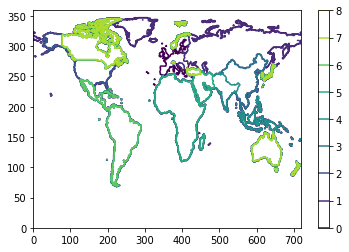

In [3]:
# DOCUMENTATION:
# naming convention:
## grid = Ilyas 36x72 grid
## mask / fullmask = 180 x 360 

# load pagemask.nc file using xarray
dsdir = '../../data/other/' # directory
dsname = 'pagemask.nc'
DS = xr.open_dataset(dsdir + dsname)
da = DS.world # select variable
mask = da.values # turn dataset into numpy array
    # NB.... mask.shape != grid.shape....

#np.place(mask, mask<1, np.nan)
plt.contour(mask)
plt.colorbar()

### Take original masking set and translate it to 8 separate masking sets (still the original high resolution) 

In [4]:
# global variables used:
# - regions

# make 8 separate 1-0 masks, full resolution
def create_separate_masks(fullmask):
    maskingset = np.zeros((len(regions),fullmask.shape[0],fullmask.shape[1]))
    for k in range (1,len(regions)+1):
        for ii in range(fullmask.shape[0]):
            for jj in range(fullmask.shape[1]):
                if fullmask[ii][jj] == k:
                    
                    maskingset[k-1][ii][jj] = 1

    return maskingset

maskingset = create_separate_masks(mask)

### Function for applying PAGE-masks to a dataset, returning dataset as 3d matrix with (coarse) coastally weighted data per gridpoint, with a dimension for every region.

In [5]:
# global variables used:
# - regions, 
# - mask, 
# - maskingset


# now, for eventual calculations, we don't create a 1/0 masking set, but rather just a weighted grid, 
# which is required because the observational temperature data is coarse. 

def create_weighted_grids(grid): # grid should be input of 36 x 72 (so for 1 time entry!!)
    weighted_grid = np.zeros((len(regions), grid.shape[0],grid.shape[1]))
    iratio = int(mask.shape[0]/grid.shape[0]) # = 10
    jratio = int(mask.shape[1]/grid.shape[1]) # = 10
    
    # on the t_anom grid.
    for k in range(len(regions)):
        for i in range(grid.shape[0]): # latitude
            for j in range(grid.shape[1]): # longitude
                weighted_grid[k][i][j] = np.mean(maskingset[k, i*iratio:(i*iratio+iratio), j*jratio:(j*jratio+jratio)]) # ratios of scaling
#                 if weighted_grid[k][i][j] == 0.:
#                     weighted_grid[k][i][j] = np.nan
    return weighted_grid        


## Reading and adjusting rectangular temperature data to find regional temperatures (based on medians of the dataset)

#### Loading data

In [6]:
# load the medians of the temperature anomalies from the datafile
dsdir = '../../data/other/' # directory
dsname = 'ensemble_statistics.ann_wrt_18501900.nc' #'median.nc'
DS = xr.open_dataset(dsdir + dsname, decode_times=False)
t_anom_ds = DS['median']     # yearly data; [167 x 36 x 72], float32
t_anom = t_anom_ds.values

6.1482916 -4.3221416
(169, 36, 72)
(8, 36, 72)


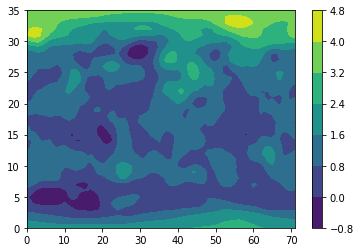

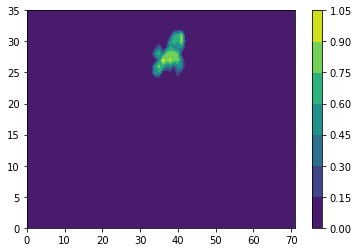

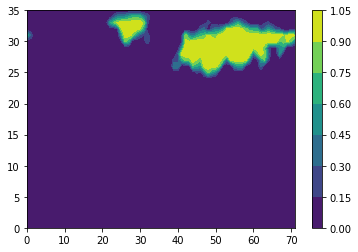

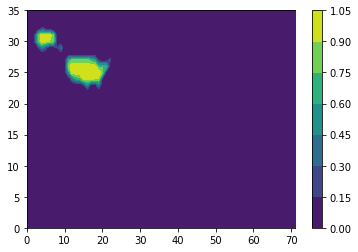

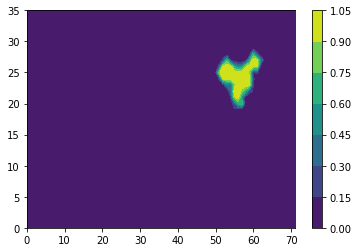

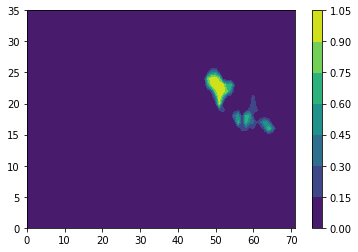

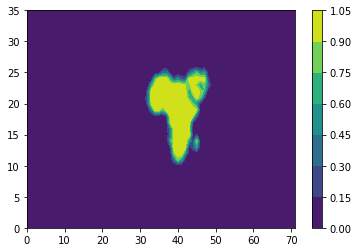

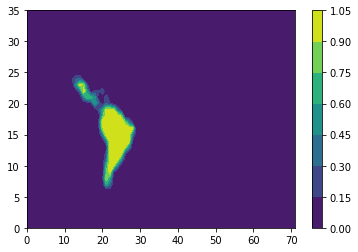

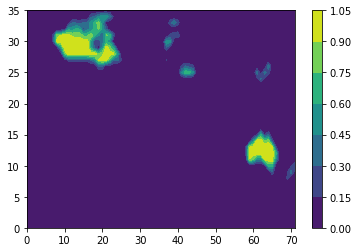

In [7]:
## Some visualisation and checking of the data loaded above:

# print some data to show some characteristic features of the dataset
print(t_anom.max(), t_anom.min())
print(t_anom.shape)

# for visualisation, plot warming pattern in the last (167th) year of analysis (currently 2016)
plt.contourf(t_anom[168])
plt.colorbar()

# call function that applies the page-ice mask and plot its result, 
## with t_anom just serving to provide info on dimensions of the data that is being analysed
weighted_grid = create_weighted_grids(t_anom[1][:][:]) # t_anom only given as argument to get the dimensions of the grid
print(weighted_grid.shape)
# check representation of continents
for i in regions:
    plt.figure()
    plt.contourf(weighted_grid[i-1])
    plt.colorbar()

# Performing analysis

### Create regional mean data, now including area weighting

In [8]:
# area weighting for when creating means, etc.
alat = np.linspace(-87.5, 87.5, 36)
def areaweight(lat):
    degree = abs(alat[lat])
    weight = np.cos(degree*np.pi/180)
    
    return weight

In [9]:
# global variables used:
# - regions
# - weighted_grid
# - numregions
# - numyears_data
# - ...

# data = t_anom

def do_regional_data(data):
    # to check the size of the input 'data' and adjust the parameters accordingly
    if data.ndim == 3:
        numyears = data.shape[0]
        grid_lat = data.shape[1]
        grid_lon = data.shape[2]
    if data.ndim == 2:
        numyears = 1
        grid_lat = data.shape[0]
        grid_lon = data.shape[1]
    
    # create variable to store processed data:
    regional_data = np.zeros((numregions, numyears)) # for storing weighted mean temperature (per year and per region)
                              
    # apply masking weights:                           
    # N.B. below highly nested loop is very slow. Is there a quicker way using Linear Algebra?
    for c in range(numregions): # run over all regions
        for year in range(numyears): # run over all years
            t_sum = 0
            areaweights_sum = 0
            for i in range(grid_lat): 
                for j in range(grid_lon):
                    # this highly nested loop applies the weights of the masked grid to the data.
                        ## apply area weighting here
                    
                    if data.ndim == 2:
                        t_sum = t_sum + data[i][j] * weighted_grid[c][i][j]*areaweight(i)
                        areaweights_sum = areaweights_sum + weighted_grid[c][i][j]*areaweight(i)
                    else:
                        t_sum = t_sum + data[year][i][j] * weighted_grid[c][i][j]*areaweight(i)
                        areaweights_sum = areaweights_sum + weighted_grid[c][i][j]*areaweight(i)
            t_mean = t_sum/areaweights_sum
            regional_data[c][year] = t_mean     
    
    return regional_data
    
regional_data = do_regional_data(t_anom)

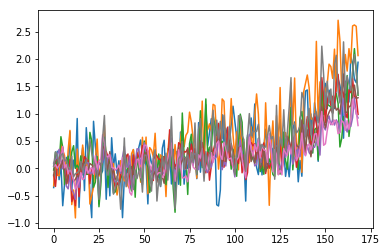

In [10]:
# check results by printing regional mean temperatures, with area weighting
plt.figure()
# plt.plot(range(regional_data.shape[1]), np.mean(global_data_detrended, axis=1))
for c in range(len(regions)):
    plt.plot(range(regional_data.shape[1]), regional_data[c])

### Write out temperatures to be used for AR model

In [11]:
np.savetxt("region-temps.csv", regional_data, delimiter=",")